# Rolling Planning mit Flow Time

In [1]:
from configs.config import get_path
import src.utils.converter as convert
import src.utils.presenter as show
import src.utils.checker as check

import src.utils.gen_jobs as gen_jobs
import src.utils.rolling_scheduling as rolling_schedule

import time
import pandas as pd
pd.set_option('display.max_rows', 26)

In [2]:
import src.models.lp.flowtime_solver as solver
from src.simulation.ProductionDaySimulation import ProductionDaySimulation

In [3]:
max_time = 60*60*5 # 5h

## Laden der Initialisierungsdaten

In [4]:
data_path = get_path("data", "lp_flowtime")

In [5]:
df_jssp = pd.read_csv(data_path / "02_flowtime_all_jssp.csv")
df_times = pd.read_csv(data_path / "02_flowtime_all_times.csv")

### Tag 0 

In [6]:
df_plan = pd.read_csv(data_path / "02_flowtime_init_plan.csv")
df_execution = pd.read_csv(data_path / "02_flowtime_execution.csv")
df_undone = pd.read_csv(data_path / "02_flowtime_init_undone.csv")

### Settings

In [7]:
def get_schedule_filename(prefix: str = "", day: int = 0, data_txt: str = "schedule", suffix: str = "") -> str:
    file_template = "{prefix}_{data}_{day:02d}{suffix}.csv"
    if suffix:
        suffix = f"_{suffix}"
    return data_path / file_template.format(prefix=prefix,data=data_txt,day=day, suffix=suffix)

## Params

In [8]:
# fix
day_length = 1440
horizon_days = 2

notebook_prefix = "3b"

#### Rescheduling für Tage 1-5

In [9]:
first_start = 1
last_planning_start = 5

BigM: 31000

Solver-Informationen:
  Zielfunktionswert       : 167803.04
  Solver-Status           : Optimal
  Anzahl Variablen        : 14442
  Anzahl Constraints      : 28309

  Scheduling-Dauer: 0 Minuten und 9.00 Sekunden.


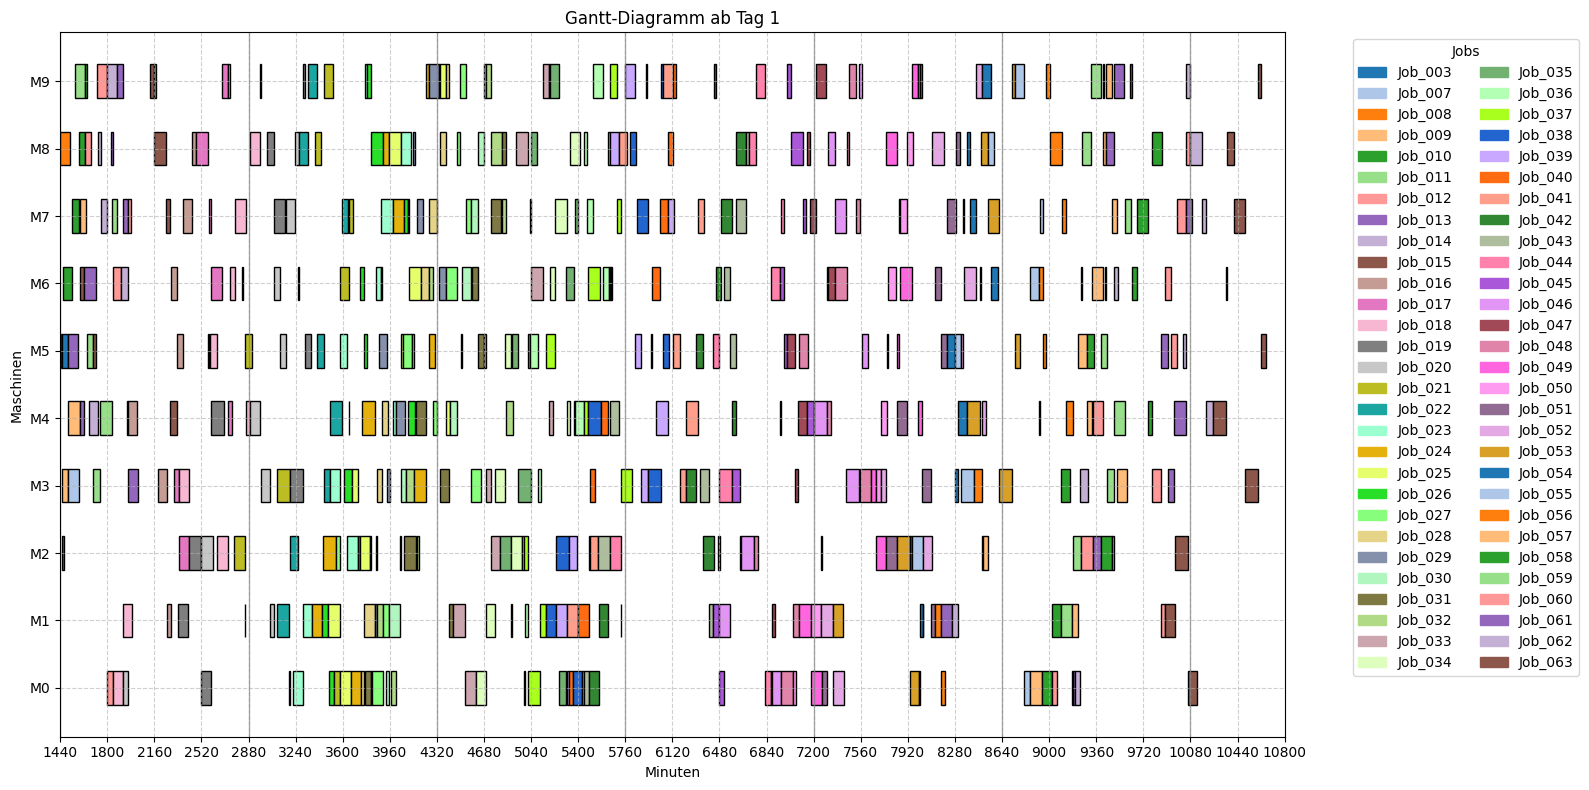

+ Keine Maschinenkonflikte gefunden
+ Alle Jobs wurden in korrekter Operationsreihenfolge ausgeführt.
+ Alle technologischen Abhängigkeiten sind eingehalten.
+ Alle Operation starten erst nach Arrival des Job

+++ Alle Constraints wurden erfüllt.

[24:00:00] Job_008 started on M8
[24:06:43] Job_010 started on M5
[24:10:28] Job_009 started on M3
[24:13:52] Job_015 started on M2
[24:16:24] Job_010 finished on M5 (after 09 minutes 40 seconds)
[24:17:43] Job_003 started on M5
[24:23:45] Job_015 finished on M2 (after 09 minutes 53 seconds)
[24:25:00] Job_010 started on M6
[24:46:03] Job_009 finished on M3 (after 35 minutes 35 seconds)
[25:02:28] Job_007 started on M3
[25:02:28] Job_009 started on M4
[25:04:06] Job_008 finished on M8 (after 64 minutes 07 seconds)
[25:07:16] Job_003 finished on M5 (after 49 minutes 32 seconds)
[25:07:16] Job_013 started on M5
[25:51:00] Job_011 started on M9
[25:57:19] Job_010 finished on M6 (after 92 minutes 19 seconds)
[25:57:19] Job_010 started on M7
[26:0

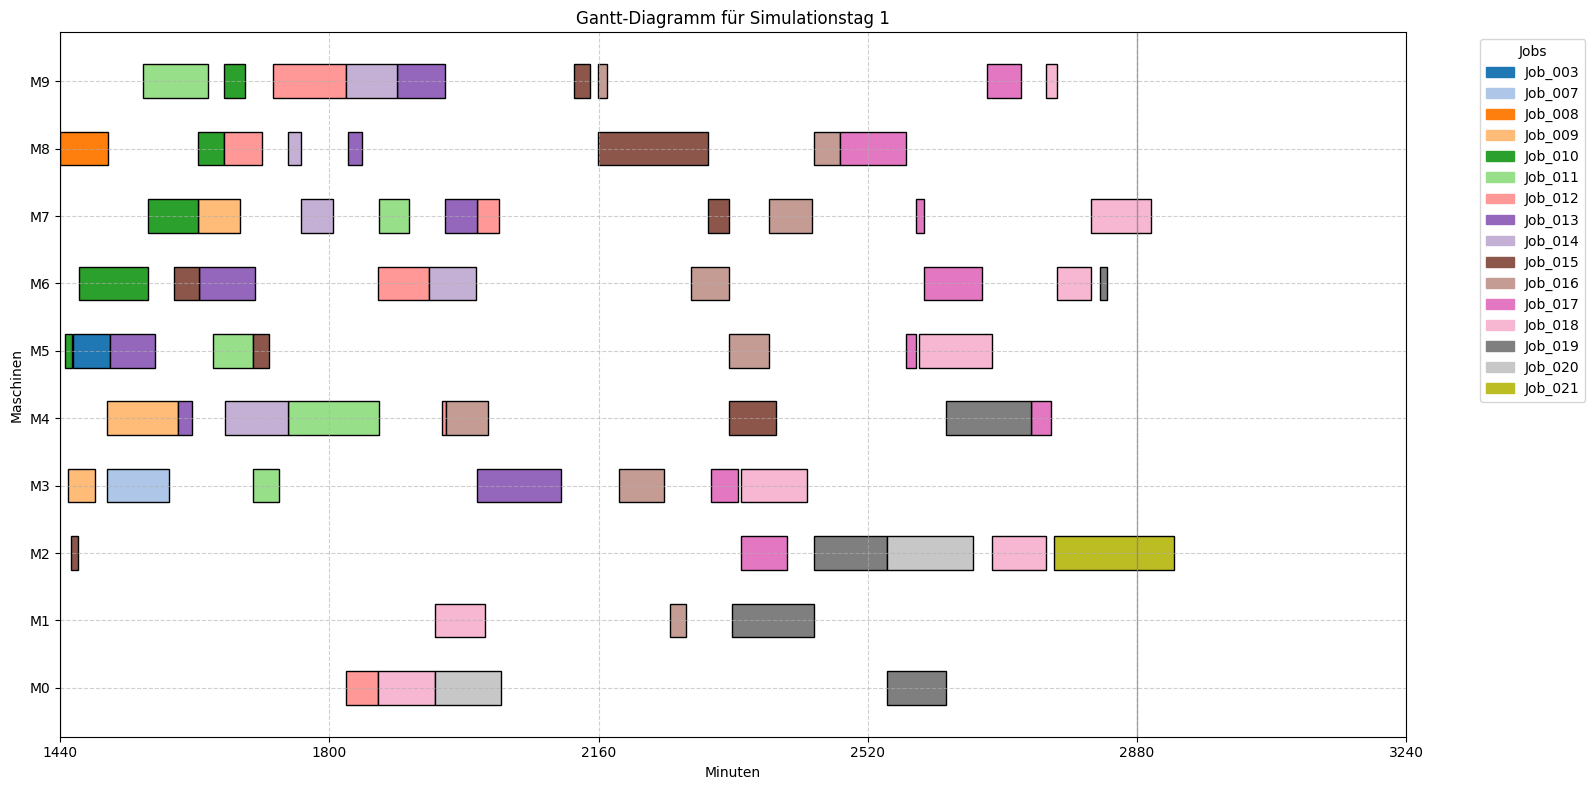

BigM: 43000


In [ ]:
for day_numb in range(first_start, last_planning_start + 1):
    day_start = day_length * day_numb
    day_end = day_start + day_length
    planning_end = day_start + horizon_days * day_length

    # ------------------- I. Ankunfts- und Operationsvorbereitung -------------------
    df_jssp_curr, df_times_curr = rolling_schedule.filter_jobs_by_arrival_window(df_times, df_jssp, day_start, planning_end)
    df_jssp_curr = rolling_schedule.extend_with_undone_operations(df_jssp_curr, df_undone)
    df_times_curr = rolling_schedule.update_times_after_operation_changes(df_times, df_jssp_curr)

    # ------------------- II. Relevante laufende Operationen -------------------------
    df_execution_important = rolling_schedule.get_operations_running_into_day(df_execution, day_start)

    # ------------------- III. Rescheduling durchführen -------------------------------

    starting_time = time.time()
    df_plan = solver.solve_jssp_flowtime_with_devpen(df_jssp_curr, df_times_curr, df_execution_important, 
                                                     df_original_plan = df_plan,
                                                     r = 0.70, # 70% Flowtime, 30% Abweichung
                                                     reschedule_start = day_start, solver= "HiGHS", 
                                                     msg=False, timeLimit=max_time, gapRel= 0.02)
    solver_duration = time.time() - starting_time
    print(f"\n  Scheduling-Dauer: {int(solver_duration // 60)} Minuten und {(solver_duration % 60):.2f} Sekunden.")

    df_plan.to_csv(get_schedule_filename(notebook_prefix, day=day_numb), index=False)

    show.plot_gantt_machines(df_plan, title=f"Gantt-Diagramm ab Tag {day_numb}")
    check.check_constraints(df_plan)

    # ------------------- IV. Einen Tag simulieren -------------------------------------

    simulation = ProductionDaySimulation(df_plan, vc=0.25)
    df_execution, df_undone = simulation.run(start_time=day_start, end_time=day_end)
    if not df_execution.empty:
        show.plot_gantt_machines(df_execution, title=f"Gantt-Diagramm für Simulationstag {day_numb}", duration_column="Simulated Processing Time")
    else:
        print(f"Nothing executed on day {day_numb}")
    
